In [12]:
from ouster import client, viz
import os
import skimage.io as io
#import open3d as o3d
import numpy as np
#import matplotlib.pyplot as plt

In [13]:
metadata_path = os.path.join('include', 'metadata.json')
image_path = os.path.join('images', 'train', 'image_100.png')

In [14]:
with open(metadata_path, 'r') as f:
    metadata = client.SensorInfo(f.read())

In [15]:
xyzlut = client.XYZLut(metadata)

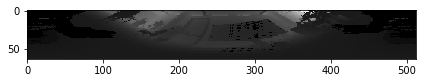

In [24]:
image = io.imread(image_path)
io.imshow((255 - image[:,:,3]))
range = (255 - image[:,:,3])*2**10

In [28]:
#destag_range = ouster.client.destagger(metadata, range, True)
#io.imshow(destag_range)

In [16]:
xyz = xyzlut(range)

In [17]:
point_viz = viz.PointViz("Example Viz")
viz.add_default_controls(point_viz)

In [19]:
cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))
#cloud_xyz.set_key(signal.ravel())
point_viz.add(cloud_xyz)

In [22]:
point_viz.update()

True

In [23]:
point_viz.run()

KeyboardInterrupt: 

In [ ]:
pcl::PointCloud<pcl::PointXYZ>::Ptr getXYZFromRangeImage(const sensor_msgs::ImageConstPtr& range_image_msg,
                                                         const std_msgs::StringConstPtr& metadata_msg)
{
  const auto cv_ptr = cv_bridge::toCvCopy(range_image_msg, sensor_msgs::image_encodings::MONO16);
  Eigen::MatrixXd eigen_image;
  cv::cv2eigen(cv_ptr->image, eigen_image);
  const Eigen::Ref<const Eigen::Array<uint32_t, -1, -1, Eigen::RowMajor>> range_image =
      eigen_image.cast<uint32_t>() * 4;

  const auto metadata = ouster::sensor::parse_metadata(metadata_msg->data);
  const auto lut =
      ouster::make_xyz_lut(metadata.format.columns_per_frame,
                           metadata.format.pixels_per_column, ouster::sensor::range_unit,
                           metadata.beam_to_lidar_transform, metadata.lidar_to_sensor_transform,
                           metadata.beam_azimuth_angles, metadata.beam_altitude_angles);

  const Eigen::ArrayX3f lut_direction = lut.direction.cast<float>();
  const Eigen::ArrayX3f lut_offset = lut.offset.cast<float>();

  const auto range_image_staggered =
      ouster::stagger(range_image, metadata.format.pixel_shift_by_row);
  Eigen::ArrayX3f cloud(lut_direction.rows(), 3);
  ouster::cartesianT(cloud, range_image_staggered, lut_direction, lut_offset);

  pcl::PointCloud<pcl::PointXYZ>::Ptr pointcloud(new pcl::PointCloud<pcl::PointXYZ>);
  pointcloud->header.frame_id = range_image_msg->header.frame_id;
  pointcloud->header.stamp = range_image_msg->header.stamp.toNSec() / 1000ull;
  pointcloud->height = range_image_msg->height;
  pointcloud->width = range_image_msg->width;
  pointcloud->is_dense = false;
  pointcloud->points.resize(pointcloud->width * pointcloud->height);
  for (size_t i = 0; i < pointcloud->points.size(); ++i)
  {
    pointcloud->points[i].x = cloud(i, 0);
    pointcloud->points[i].y = cloud(i, 1);
    pointcloud->points[i].z = cloud(i, 2);
  }
  return pointcloud;
}